## Summary
Ok, we know that taking some continuous variables out of the mix improves the score. Now, I want to try using one-hot encoding on the categorical variables, removing highly correlated variables, and tweaking the RF parameters. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from copy import deepcopy
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [12]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(os.path.join(loc,'train.csv'))
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [14]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


In [16]:
newlist = deepcopy(keepcont)
newlist.remove("cont1")
newlist.remove("cont11")
newlist.remove("cont6")
newlist.append("loss")

dataset = train[newlist]
dataset['loss']=np.log(dataset['loss'])
dataset.rename(columns={'loss':'log-loss'},inplace=True)
dataset.head()

/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,cont14,log-loss
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,0.714843,7.702186
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,0.304496,7.157424
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,0.774425,8.008063
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,0.602642,6.845720
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,0.432606,7.924380


### Categorical variables
One-hot encoding, and thinning of feature list.

In [32]:
## Now let's code up the categorical data (0's and 1's instead of ABC's)
labels = []
cols = train.columns
newlabels = []
for i in range(0,116):
    trainer = train[cols[i]].unique()
    tester = test[cols[i]].unique()
    # We want the intersection of labels from the training and testing datasets
    # in case there are labels in the test dataset that don't show up in the training dataset.
    labels.append(list(set(trainer) | set(tester)))    
    
    for thing in labels[-1]:
        newlabels.append(cols[i]+'-'+str(thing))

#One hot encode all categorical attributes
cats = []
for i in range(0, 116):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(train.iloc[:,i])
    feature = feature.reshape(train.shape[0], 1)
    
    
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    cats.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats = np.column_stack(cats)
print len(newlabels)
print encoded_cats.shape

1176
(188318, 1176)


In [62]:
# Based on analysis done in Kaggle forum, get rid of a couple highly
# correlated categorical variables:
get_rid_of = list(['cat2-','cat6-','cat8-','cat7-','cat16-'])
new_cat_list = []

for lab in newlabels:
    ans = 'yes'
    for bad in get_rid_of:
        if bad in lab:
            ans = 'no'
            
    if ans=='yes':
        new_cat_list.append(lab)

print len(newlabels),len(new_cat_list)

1176 1166


In [69]:
inds = [i for i in range(len(newlabels)) if newlabels[i] in new_cat_list]
df = pd.DataFrame(encoded_cats[:,inds],columns=new_cat_list)

In [70]:
# Merge continuous and categorical
final_data = pd.concat([dataset,df],axis=1)

y = final_data['log-loss']
x = final_data.drop('log-loss',axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5)
model_some = RandomForestRegressor(n_estimators=50,n_jobs=-1,random_state=0)

model_some.fit(X_train,y_train)
x_pred = model_some.predict(X_test)

mae_some = mean_absolute_error(np.exp(y_test),np.exp(x_pred))



#_--------------------------
catdf = pd.DataFrame(encoded_cats,columns=newlabels)
final_full = pd.concat([dataset,catdf],axis=1)
y2 = final_full['log-loss']
x2 = final_full.drop('log-loss',axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=.5)
model_all = RandomForestRegressor(n_estimators=50,n_jobs=-1,random_state=0)

model_all.fit(X_train2,y_train2)
x_pred2 = model_all.predict(X_test2)

mae_all = mean_absolute_error(np.exp(y_test2),np.exp(x_pred2))

print 'All categorical: ',mae_all
print 'Some categorical: ',mae_some

All categorical:  1217.57527133
Some categorical:  1225.38317237


## Play with RF parameters


20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


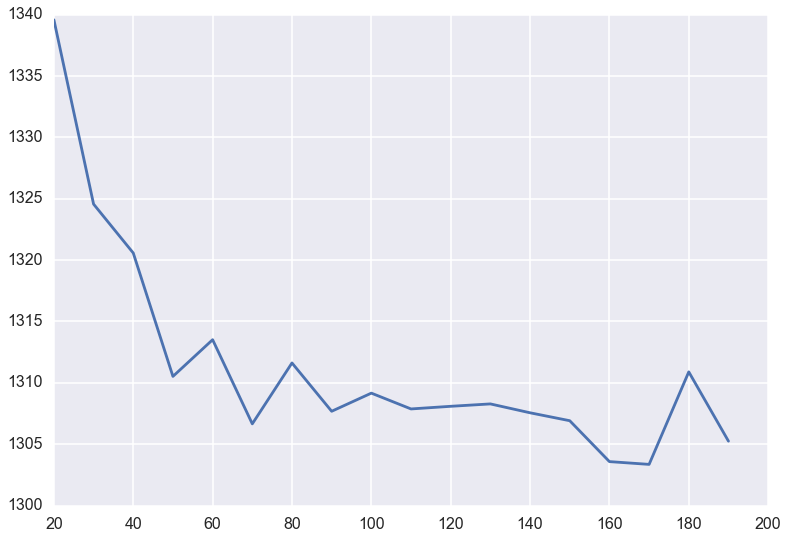

In [77]:
nestimators = np.arange(20,200,10)
maes = []

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.8)
for nest in nestimators:
    print nest
    model = RandomForestRegressor(n_estimators=nest,max_features=10)
    model.fit(X_train,y_train)
    maes.append(mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test))))
    
sns.set_context('poster')
plt.plot(nestimators,maes)


10
20
30
40
50
60
70
80
90
100
110


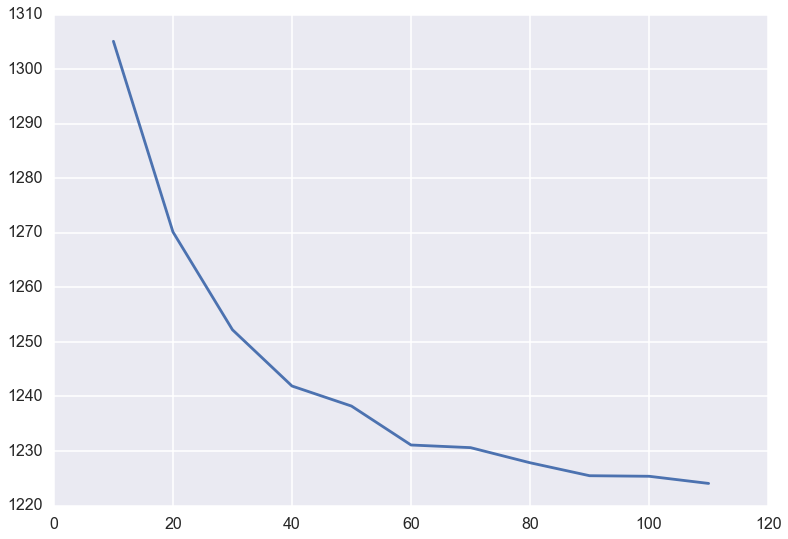

In [78]:
maxfeatures = np.arange(10,120,10)
maes = []

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.8)
for mf in maxfeatures:
    print mf
    model = RandomForestRegressor(n_estimators=160,max_features=mf)
    model.fit(X_train,y_train)
    maes.append(mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test))))
    
sns.set_context('poster')
plt.plot(maxfeatures,maes)

5
10
15
20
25


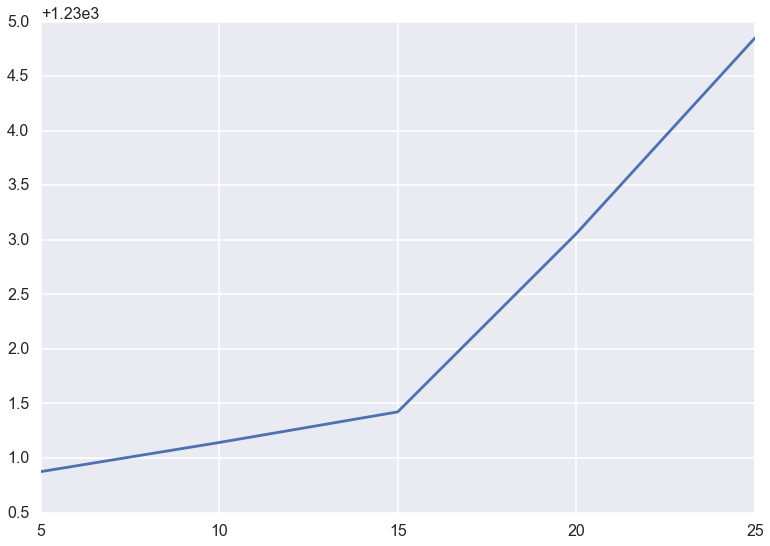

In [82]:
minsplit = np.arange(5,30,5)
maes = []
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.8)
for ms in minsplit:
    print ms
    model = RandomForestRegressor(n_estimators=160,max_features=100,min_samples_split=ms)
    model.fit(X_train,y_train)
    maes.append(mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test))))
    
sns.set_context('poster')
plt.plot(minsplit,maes)

In [85]:
# Organize test data:
cats2 = []
for i in range(0, 116):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(test.iloc[:,i])
    feature = feature.reshape(test.shape[0], 1)
    
    
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    cats2.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats2 = np.column_stack(cats2)

testlist = deepcopy(newlist)
testlist.remove('loss')
test_dataset = test[testlist]
df = pd.DataFrame(encoded_cats2[:,inds],columns=new_cat_list)

test_dataset = pd.concat([test_dataset,df],axis=1)
test_dataset.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,...,cat116-AP,cat116-AS,cat116-AR,cat116-AU,cat116-AT,cat116-AW,cat116-AV,cat116-AY,cat116-AX,cat116-N
0,0.299102,0.246911,0.402922,0.281143,0.317681,0.61229,0.34365,0.38016,0.369858,0.704052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.620805,0.654310,0.946616,0.836443,0.443760,0.71330,0.51890,0.60401,0.675759,0.453468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.737068,0.711159,0.412789,0.718531,0.325779,0.29758,0.34365,0.30529,0.241676,0.258586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.681761,0.592681,0.354893,0.397069,0.342355,0.40028,0.33237,0.31480,0.341872,0.592264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.299102,0.263570,0.696873,0.302678,0.391833,0.23688,0.43731,0.50556,0.352251,0.301535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


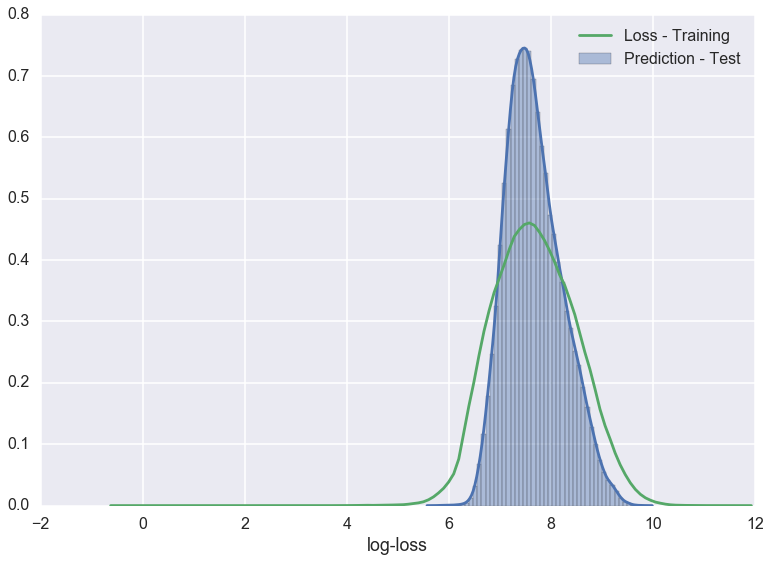

In [87]:
# Use full dataset to make a model
model = RandomForestRegressor(n_estimators=160,max_features=80,min_samples_split=5)
model.fit(x,y)

submission.iloc[:, 1] = np.exp(model.predict(test_dataset))
submission.to_csv(loc+'random_forest4.csv', index=None)

fig,ax = plt.subplots()
sns.distplot(model.predict(test_dataset),ax=ax,label='Prediction - Test')
sns.distplot(y,hist=False,ax=ax,label='Loss - Training')
plt.legend()